In [1]:
# Mount google drive to allow access to your files
from google.colab import drive
drive.mount('/content/drive')
drive_folder = '/content/drive/MyDrive'
# Ajust this line to be the assignment1 folder in your google drive
notebook_folder = drive_folder + '/INFO490PI'
%cd {notebook_folder}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/INFO490PI


In [2]:
import pandas as pd
import numpy as np

# Read CSV and comvert it into a pandas dataframe
records_df = pd.read_csv('data/apple_health_export_2024-04-15.csv')

print(records_df)

C:\Users\Aaron\AppData\Local\Temp\ipykernel_6532\3966632629.py:5: DtypeWarning: Columns (0,1,3,4,5,6,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  records_df = pd.read_csv('data/apple_health_export_2024-04-15.csv')


                          type     sourceName     value   unit  \
0            BasalEnergyBurned  iPhone 13 (2)    14.496    Cal   
1       DistanceWalkingRunning  iPhone 13 (2)  0.138595     mi   
2                    StepCount  iPhone 13 (2)       321  count   
3           ActiveEnergyBurned  iPhone 13 (2)    11.482    Cal   
4            BasalEnergyBurned  iPhone 13 (2)    16.085    Cal   
...                        ...            ...       ...    ...   
105467                     NaN            NaN       NaN    NaN   
105468                     NaN            NaN       NaN    NaN   
105469                     NaN            NaN       NaN    NaN   
105470                     NaN            NaN       NaN    NaN   
105471                     NaN            NaN       NaN    NaN   

                        startDate                    endDate  \
0       2024-04-15 14:23:34 -0400  2024-04-15 14:38:00 -0400   
1       2024-04-15 14:12:05 -0400  2024-04-15 14:16:38 -0400   
2       2024-04

In [3]:
# save date data into datetime format
# Convert data to datetime format
date_col = ['creationDate', 'startDate', 'endDate']
records_df[date_col] = records_df[date_col].apply(pd.to_datetime)

In [4]:
# get step count and sleep data
step_df = records_df.query("type == 'HKQuantityTypeIdentifierStepCount'")
# Try doing it using a different method..
step_df

,type,sourceName,value,unit,startDate,endDate,creationDate,CardioFitnessMedicationsUse,bpm,DateOfBirth,time,BiologicalSex,FitzpatrickSkinType,sourceVersion,device,locale,BloodType,key


In [5]:
no_cross = step_df[step_df["startDate"].dt.day == step_df["endDate"].dt.day]
cross = step_df[step_df["startDate"].dt.day != step_df["endDate"].dt.day]
c1 = cross.copy()
c2 = cross.copy()
c1["endDate"] = c1["startDate"].apply(lambda x: x.replace(hour=23, minute=59, second=59))
c2["startDate"] = c2["endDate"].apply(lambda x: x.replace(hour=0, minute=0, second=0))
step_splitted_df = pd.concat([no_cross, c1, c2]).sort_values("startDate")
step_splitted_df = step_splitted_df.set_index(np.arange(len(step_splitted_df["startDate"])))


In [6]:
step_splitted_df["startDate"] = step_splitted_df["startDate"].apply(lambda x: x.date)
step_splitted_df["value"] = step_splitted_df["value"].apply(pd.to_numeric)

In [7]:
step_parts = step_splitted_df[step_splitted_df["startDate"] < pd.Timestamp(2023, 1, 1)]
step_parts = step_parts[step_parts["startDate"] > pd.Timestamp(2021, 12, 31)]
step_parts

TypeError: Invalid comparison between dtype=datetime64[ns, UTC-04:00] and Timestamp

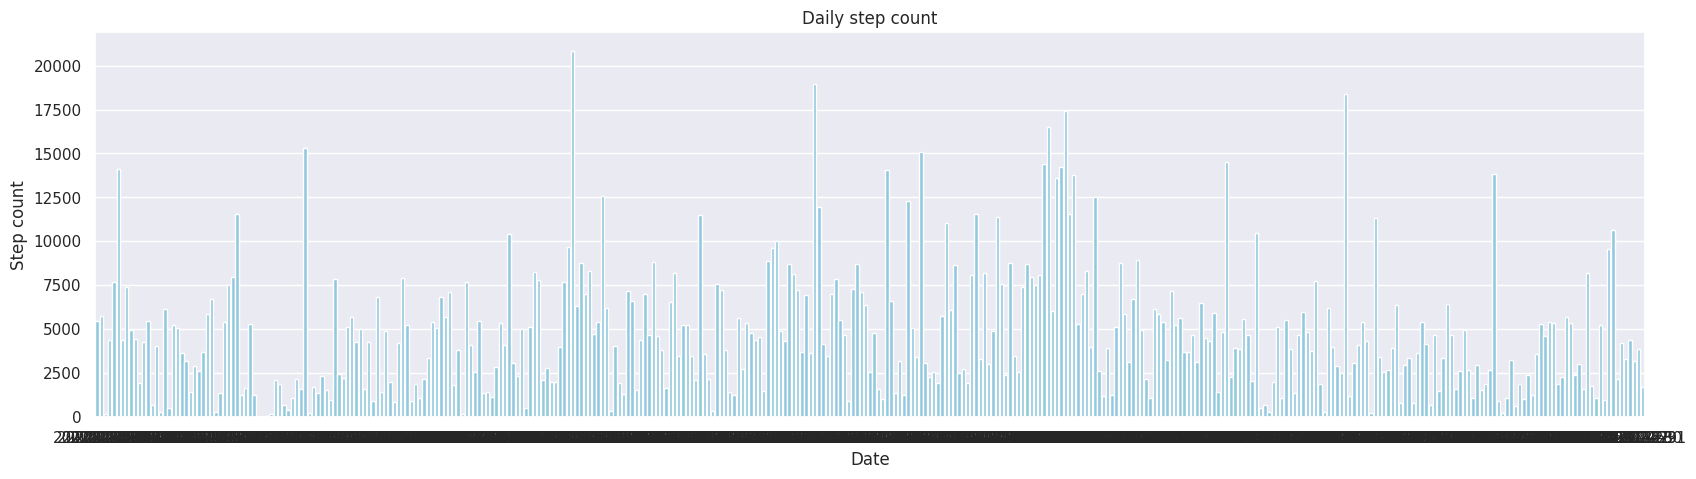

In [ ]:
# import seaborn as sns
import matplotlib.pyplot as plt

# sns.set()

plt.figure(figsize=(20, 5))
sns.barplot(x="startDate", y="value", data=step_parts, errorbar=None, estimator=sum, color='skyblue')
# plt.xticks(rotation=45)
plt.ylabel('Step count')
plt.xlabel('Date')
plt.title('Daily step count')
plt.show()

In [15]:
import numpy as np


daily_step_count = step_parts.groupby("startDate").agg('sum', "value")

csv_info = pd.DataFrame({'dailyStep': daily_step_count["value"],
    'sleepQuality': np.random.randint(1, 6, size=len(np.unique(step_parts["startDate"]))),
    'studyHour': round(daily_step_count["value"] / 10000 + abs(np.random.randn(len(np.unique(step_parts["startDate"])))*1.5))
                        })

csv_info.to_csv('daily_step_sleep_quality_study_hour.csv')

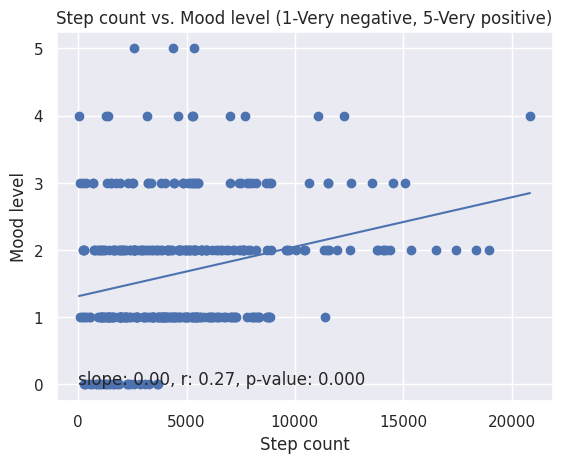

In [16]:
from scipy.stats import linregress


daily_step_count = step_parts.groupby("startDate").agg('sum', "value")
daily_step_count = daily_step_count["value"]
plt.figure()
plt.scatter(daily_step_count, csv_info["studyHour"])
# plt.ylim([0, 6])
slope, intercept, rvalue, pvalue, _ = linregress(daily_step_count, csv_info["studyHour"])
x_val = np.linspace(min(daily_step_count), max(daily_step_count), 100)
plt.plot(x_val, x_val * slope + intercept) # y = slope * x + intercept
plt.xlabel('Step count')
plt.ylabel('Mood level')
plt.title('Step count vs. Mood level (1-Very negative, 5-Very positive)')
plt.annotate('slope: {:.2f}, r: {:.2f}, p-value: {:.3f}'.format(slope, rvalue, pvalue), (1, 0))
plt.show()